<a href="https://colab.research.google.com/github/skumbham/PPE-Detection-Using-Yolo11/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1aa2d96b-8b35-45fc-a2ba-85eead44bcd5)


In [2]:
# Required Installations apart from what already present in Colab

!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 19.7 MB/s eta 0:00:00


In [3]:
# Keeping the Code Clean

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import the Dataset from Roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="zBx9nLSC08D5wkJpQVQW")
project = rf.workspace("roboflow-universe-projects").project("construction-site-safety")
version = project.version(28)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Construction-Site-Safety-28 in yolov11:: 100%|██████████| 5614/5614 [00:01<00:00, 3148.68it/s]


# **EDA**



In [5]:
import yaml
import os

# Load the YAML file
yaml_path = 'Construction-Site-Safety-28/data.yaml'
with open(yaml_path, 'r') as file:
  data = yaml.safe_load(file)

# Extract class names
class_names = data['names']

# Paths to the directories containing the YOLO annotations
train_annotations_path = 'Construction-Site-Safety-28/train/labels'
val_annotations_path = 'Construction-Site-Safety-28/valid/labels'
test_annotations_path = 'Construction-Site-Safety-28/test/labels'

# Define paths to the image directories
base_path = 'Construction-Site-Safety-28'
train_images_path = os.path.join(base_path, 'train/images')
val_images_path = os.path.join(base_path, 'valid/images')
test_images_path = os.path.join(base_path, 'test/images')

In [6]:
# Count of Images
def count_images(images_path):
  return len([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

train_count = count_images(train_images_path)
val_count = count_images(val_images_path)
test_count = count_images(test_images_path)
total_count = train_count + val_count + test_count

print(f"Total number of images: {total_count}")
print(f"Number of training images: {train_count}")
print(f"Number of validation images: {val_count}")
print(f"Number of test images: {test_count}")

Total number of images: 2801
Number of training images: 2605
Number of validation images: 114
Number of test images: 82


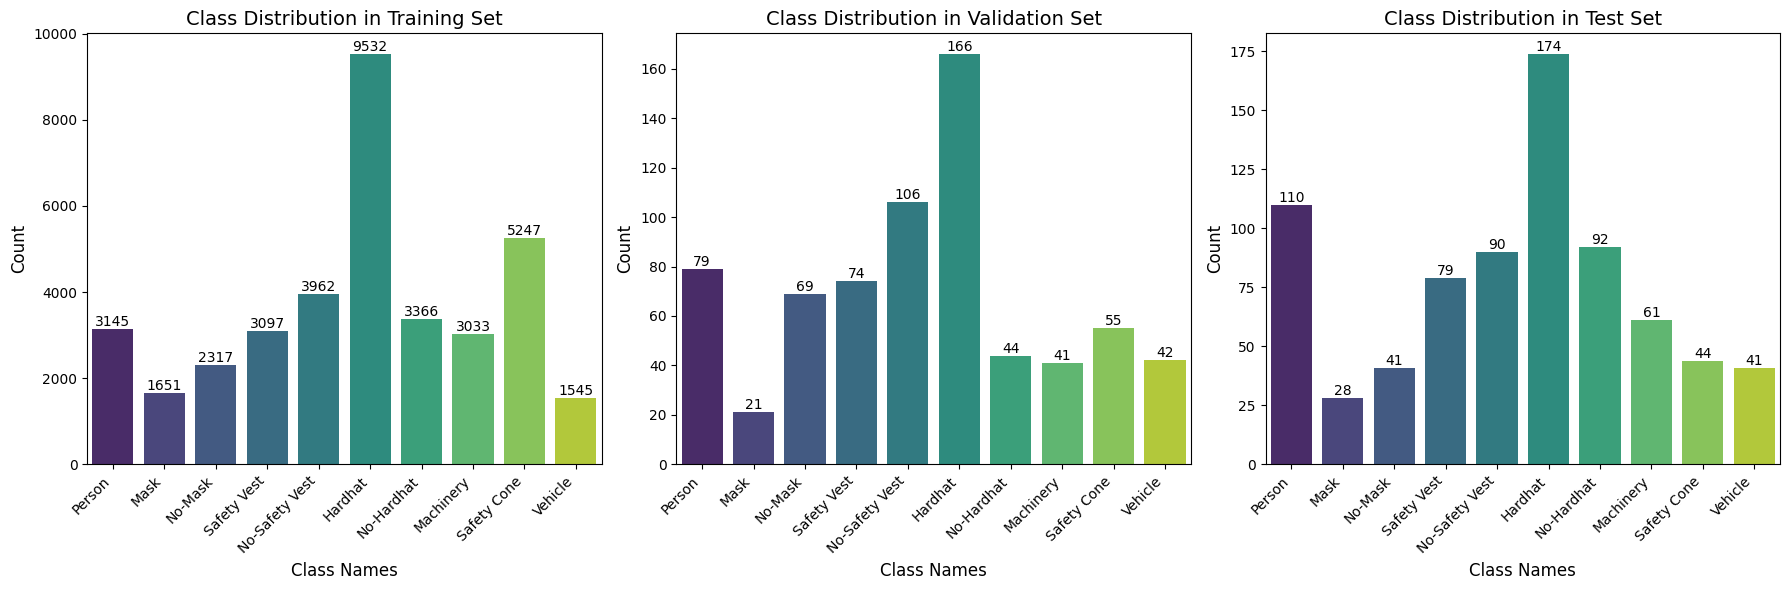

In [8]:
from collections import Counter
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to count the classes in the YOLO annotation files
def count_classes(annotations_path, class_names):
    class_counter = Counter({class_name: 0 for class_name in class_names})  # Initialize to include all classes
    for label_file in os.listdir(annotations_path):
        if label_file.endswith('.txt'):
            file_path = os.path.join(annotations_path, label_file)
            with open(file_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_names[class_id]] += 1
    return class_counter

# Function to handle subplots
def plot_class_distribution_subplot(ax, class_counts, dataset_type, class_names):
    # Align the counts with the fixed order of class_names
    counts_ordered = [class_counts[class_name] for class_name in class_names]
    bars = sns.barplot(x=class_names, y=counts_ordered, palette="viridis", ax=ax)
    ax.set_title(f'Class Distribution in {dataset_type} Set', fontsize=14)
    ax.set_xlabel('Class Names', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # Annotate bars with the actual count values
    for bar in bars.patches:
        bar_height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{int(bar_height)}', ha='center', va='bottom', fontsize=10)

# List of class names in the desired order
class_names = ['Person', 'Mask', 'No-Mask', 'Safety Vest', 'No-Safety Vest', 'Hardhat', 'No-Hardhat', 'Machinery', 'Safety Cone', 'Vehicle']

# Count classes for each dataset
train_class_counts = count_classes(train_annotations_path, class_names)
val_class_counts = count_classes(val_annotations_path, class_names)
test_class_counts = count_classes(test_annotations_path, class_names)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_class_distribution_subplot(axs[0], train_class_counts, 'Training', class_names)
plot_class_distribution_subplot(axs[1], val_class_counts, 'Validation', class_names)
plot_class_distribution_subplot(axs[2], test_class_counts, 'Test', class_names)

# Adjust layout
plt.tight_layout()
plt.show()


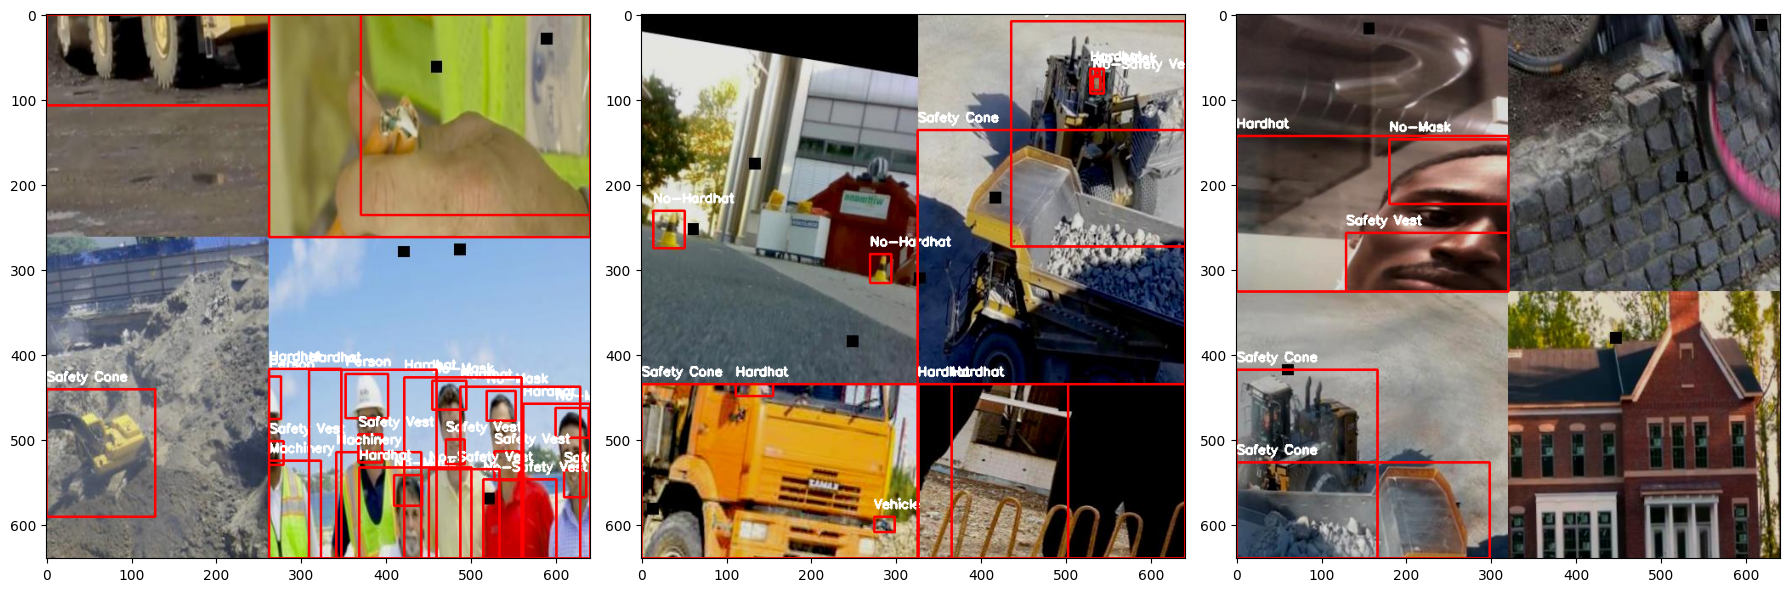

In [11]:
import cv2
import random

# Display images with bounding boxes and annotated labels from YOLO format
def display_images_with_boxes(images_path, annotations_path, class_names, num_images=3):
    selected_images = random.sample([f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))], num_images)
    fig, axs = plt.subplots(1, num_images, figsize=(18, 6))

    for i, image_file in enumerate(selected_images):
        # Load the image
        image = cv2.cvtColor(cv2.imread(os.path.join(images_path, image_file)), cv2.COLOR_BGR2RGB)

        # Read bounding boxes and draw them
        with open(os.path.join(annotations_path, os.path.splitext(image_file)[0] + '.txt')) as file:
            for line in file:
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.split())
                x1, y1 = int((x_center - bbox_width / 2) * image.shape[1]), int((y_center - bbox_height / 2) * image.shape[0])
                x2, y2 = int((x_center + bbox_width / 2) * image.shape[1]), int((y_center + bbox_height / 2) * image.shape[0])
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(image, class_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        axs[i].imshow(image)
        axs[i].axis('on')

    plt.tight_layout()
    plt.show()

# Call the function to display three images with bounding boxes and labels
display_images_with_boxes(train_images_path, train_annotations_path, class_names, num_images=3)


In [10]:
# Import the Pre-Trained Model
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 83.4MB/s]


In [16]:
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("yolov8s.pt")  # Replace with your desired YOLO model weights

# Define training parameters
data_yaml_path = "/content/Construction-Site-Safety-28/data.yaml"  # Path to your dataset YAML file
imgsz = (640, 640)  # Specify image size (height, width)
epochs = 50  # Total number of training epochs
batch_size = 16  # Batch size
optimizer = "auto"  # Optimization algorithm (auto lets YOLO decide the best)
lr0 = 1e-3  # Initial learning rate
lrf = 0.01  # Final learning rate factor
weight_decay = 5e-4  # Weight decay
dropout = 0.0  # Dropout
patience = 20  # Early stopping patience
label_smoothing = 0.0  # Label smoothing factor
experiment_name = "ppe_css_50_epochs"  # Name of the experiment
device_id = 0  # Single GPU device ID
profile = False  # Disable profiling during training

In [17]:
# Train the model
model.train(
    data=data_yaml_path,
    task="detect",
    imgsz=imgsz,
    epochs=epochs,
    batch=batch_size,
    optimizer=optimizer,
    lr0=lr0,
    lrf=lrf,
    weight_decay=weight_decay,
    dropout=dropout,
    patience=patience,
    profile=profile,
    label_smoothing=label_smoothing,
    name=experiment_name,
    seed=88,  # Seed for reproducibility
    val=True,  # Enable validation
    amp=True,  # Automatic mixed precision training
    exist_ok=True,  # Overwrite existing experiment folder
    resume=False,  # Do not resume previous training
    device=device_id,  # GPUs to use
    verbose=False,  # Suppress training logs
)


Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/Construction-Site-Safety-28/data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 20.8MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

train: Scanning /content/Construction-Site-Safety-28/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:01<00:00, 1795.32it/s]

train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Construction-Site-Safety-28/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed
train: New cache created: /content/Construction-Site-Safety-28/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Construction-Site-Safety-28/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1412.68it/s]

val: New cache created: /content/Construction-Site-Safety-28/valid/labels.cache


Plotting labels to runs/detect/ppe_css_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.46G      1.314       2.05      1.443        306        640: 100%|██████████| 163/163 [01:00<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.655        0.5      0.554      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.15G        1.2      1.434      1.355        244        640: 100%|██████████| 163/163 [00:57<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

                   all        114        697      0.602      0.497      0.537      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.86G      1.204      1.375      1.351        346        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


                   all        114        697      0.629      0.515      0.527      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.21G       1.18      1.308      1.336        313        640: 100%|██████████| 163/163 [00:57<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


                   all        114        697       0.67      0.543      0.593      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.98G       1.16      1.252       1.32        316        640: 100%|██████████| 163/163 [00:56<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        114        697      0.734      0.544      0.621      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.54G      1.134      1.207      1.303        251        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


                   all        114        697      0.703      0.563      0.617      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.55G      1.112      1.148      1.283        222        640: 100%|██████████| 163/163 [00:57<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        114        697      0.697      0.595      0.631       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.04G      1.091      1.096      1.269        246        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        114        697      0.795      0.617      0.681      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.8G      1.072      1.062      1.256        441        640: 100%|██████████| 163/163 [00:57<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


                   all        114        697      0.846      0.592       0.68      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.67G      1.055      1.023      1.242        290        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        114        697      0.744      0.619      0.657      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.68G      1.027     0.9997       1.23        301        640: 100%|██████████| 163/163 [00:56<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]

                   all        114        697      0.866      0.626      0.716      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.19G      1.017     0.9673      1.222        284        640: 100%|██████████| 163/163 [00:58<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        114        697      0.825      0.641      0.713      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.77G      1.003     0.9463       1.21        186        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


                   all        114        697      0.829      0.636      0.722      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.04G     0.9919     0.9136      1.199        235        640: 100%|██████████| 163/163 [00:56<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


                   all        114        697      0.816      0.665       0.73      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.18G     0.9714      0.884       1.19        283        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        114        697      0.838      0.686      0.755      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.81G     0.9684     0.8705      1.185        332        640: 100%|██████████| 163/163 [00:57<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        114        697      0.843      0.678      0.741      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.48G     0.9531     0.8532      1.174        276        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        114        697      0.766      0.723      0.757       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.47G     0.9513     0.8467      1.175        433        640: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        114        697      0.833      0.689       0.76      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.99G     0.9344     0.8157      1.158        266        640: 100%|██████████| 163/163 [00:56<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        114        697      0.846      0.679      0.756      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.64G     0.9249     0.8123      1.158        280        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        114        697      0.835      0.706      0.773      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.57G     0.9118     0.7935      1.147        367        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


                   all        114        697      0.888      0.706       0.78      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.79G     0.8979     0.7572      1.134        400        640: 100%|██████████| 163/163 [00:57<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]

                   all        114        697      0.844        0.7       0.78      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.59G     0.8877     0.7626      1.133        242        640: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        697      0.865       0.69       0.78      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.85G     0.8815     0.7462      1.128        321        640: 100%|██████████| 163/163 [00:56<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        114        697      0.873      0.736      0.802      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.66G     0.8697      0.725      1.118        334        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        114        697      0.853      0.731      0.796      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.95G     0.8626     0.7161      1.112        305        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        114        697      0.869      0.727      0.794      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.74G     0.8512     0.7058      1.107        268        640: 100%|██████████| 163/163 [00:56<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        114        697      0.867      0.724      0.804      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.62G     0.8367     0.6866      1.099        196        640: 100%|██████████| 163/163 [00:57<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        114        697      0.894       0.72      0.804       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.18G     0.8315     0.6787      1.093        184        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        114        697      0.897      0.735      0.829      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.42G     0.8215     0.6705      1.088        194        640: 100%|██████████| 163/163 [00:57<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        114        697      0.897      0.711      0.815       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.77G      0.818     0.6639      1.092        281        640: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        114        697      0.897      0.719      0.798      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.76G     0.8145     0.6556      1.086        290        640: 100%|██████████| 163/163 [00:56<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        114        697      0.911      0.715       0.81      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.93G     0.7972     0.6427      1.072        305        640: 100%|██████████| 163/163 [00:57<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        114        697      0.894      0.735      0.819      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         5G     0.7852     0.6278       1.07        282        640: 100%|██████████| 163/163 [00:58<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        114        697      0.903      0.723      0.826      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.54G      0.794     0.6353      1.072        296        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        114        697       0.87      0.749      0.825      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.62G     0.7763     0.6146      1.068        287        640: 100%|██████████| 163/163 [00:56<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        114        697      0.909      0.741      0.831       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       5.1G     0.7668     0.6097      1.059        224        640: 100%|██████████| 163/163 [00:59<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        114        697      0.931      0.737      0.827      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.65G     0.7576      0.596      1.052        250        640: 100%|██████████| 163/163 [00:57<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        114        697      0.911      0.755      0.838      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.84G       0.75      0.591      1.049        262        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        114        697      0.915      0.749       0.83      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.51G     0.7406     0.5822      1.042        253        640: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        114        697      0.905      0.758      0.835       0.53


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.36G     0.7545     0.5203      1.043        168        640: 100%|██████████| 163/163 [00:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        114        697      0.906      0.763      0.838      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.56G     0.7314     0.4885      1.033        145        640: 100%|██████████| 163/163 [00:54<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        114        697       0.93      0.763      0.841       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.34G      0.719     0.4828      1.026        141        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        697      0.924      0.757      0.838      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.37G     0.7083     0.4703      1.016        184        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


                   all        114        697      0.892      0.775      0.844      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.39G     0.6976     0.4666      1.013        217        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        697      0.923      0.756      0.843      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.07G     0.6928     0.4593      1.011        182        640: 100%|██████████| 163/163 [00:54<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        114        697      0.928      0.771       0.85      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.39G     0.6828     0.4558      1.007        136        640: 100%|██████████| 163/163 [00:53<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        114        697      0.901      0.777      0.844      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.39G     0.6714     0.4449          1        148        640: 100%|██████████| 163/163 [00:57<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all        114        697      0.939      0.769      0.845      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.23G     0.6658     0.4419      0.995        157        640: 100%|██████████| 163/163 [00:54<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        114        697      0.924      0.771      0.852      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.29G     0.6581      0.432     0.9926        141        640: 100%|██████████| 163/163 [00:54<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        114        697      0.912      0.776      0.846      0.563



50 epochs completed in 0.828 hours.
Optimizer stripped from runs/detect/ppe_css_50_epochs/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/ppe_css_50_epochs/weights/best.pt, 22.5MB

Validating runs/detect/ppe_css_50_epochs/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


                   all        114        697      0.924       0.77      0.852      0.565
Speed: 0.3ms preprocess, 5.4ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/ppe_css_50_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7887a2b938b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [18]:
results = model.val(data="/content/Construction-Site-Safety-28/data.yaml", split="test")
print(results)


Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/Construction-Site-Safety-28/test/labels... 82 images, 8 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<00:00, 752.27it/s]

val: New cache created: /content/Construction-Site-Safety-28/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


                   all         82        760      0.893      0.748      0.799       0.51
Speed: 0.4ms preprocess, 11.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/ppe_css_50_epochs
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7887a2625240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03

In [19]:
# Export the model to TFLite format
model.export(format="tflite")

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/ppe_css_50_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (21.5 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 259.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 172.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 271.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 347.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 75.3 M

100%|██████████| 1.11M/1.11M [00:00<00:00, 29.8MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 35.11file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.39...
ONNX: export success ✅ 3.1s, saved as 'runs/detect/ppe_css_50_epochs/weights/best.onnx' (42.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 53.0s, saved as 'runs/detect/ppe_css_50_epochs/weights/best_saved_model' (106.9 MB)

TensorFlow Lite: starting export with tensorflow 2.17.1...
TensorFlow Lite: export success ✅ 0.0s, saved as 'runs/detect/ppe_css_50_epochs/weights/best_saved_model/best_float32.tflite' (42.7 MB)

Export complete (55.3s)
Results saved to /content/runs/detect/ppe_css_50_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/ppe_css_50_epochs/weights/best_saved_model/best_float32.tflite imgsz=640  
Validate:        yolo val task=detect model=runs/detect/ppe_css_50_epochs/weights/best_saved_model/best_float32.tflite imgsz=640 data=/content/Construction-Site-Safety-28/data.yaml  
Visualize:       https://netron.app


'runs/detect/ppe_css_50_epochs/weights/best_saved_model/best_float32.tflite'

In [20]:
import shutil

# Path to the directory you want to zip
directory_to_zip = "/content/runs"

# Output zip file path
output_zip_path = "/content/runs.zip"

# Create a zip archive
shutil.make_archive("/content/runs", 'zip', directory_to_zip)

# Provide the download link
output_zip_path


'/content/runs.zip'

# **Citations and Acknowledgements**

```
@software{yolo11_ultralytics,
  author = {Glenn Jocher and Jing Qiu},
  title = {Ultralytics YOLO11},
  version = {11.0.0},
  year = {2024},
  url = {https://github.com/ultralytics/ultralytics},
  orcid = {0000-0001-5950-6979, 0000-0002-7603-6750, 0000-0003-3783-7069},
  license = {AGPL-3.0}
}
```

